# Laboratory 5: Convolutional Neural Networks

In this laboratory session we will train some CNNs to recognize color images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1: Initial Setup and Data Exploration

We begin with some standard imports, as usual.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616)) # mean and std of CIFAR10
])

# Validation set size.
val_size = 2000

# Load the MNIST training and test splits.
ds_orig = CIFAR10(root='./data', download=True, train=True)
ds_train = CIFAR10(root='./data', download=True, train=True, transform=transform)
ds_test  = CIFAR10(root='./data', download=True, train=False, transform=transform)

# Randomly split training set into train and val.
(ds_train, ds_val) = torch.utils.data.random_split(ds_train, (len(ds_train)-val_size, val_size))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [3]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256

dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size)

# format channel/width/height

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])


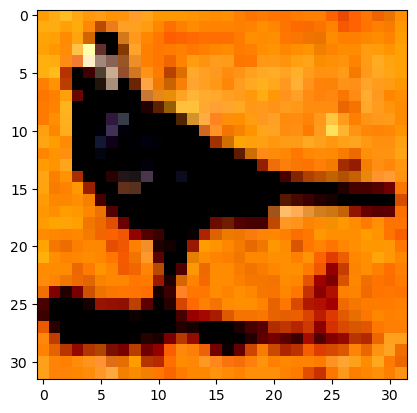

Label: bird


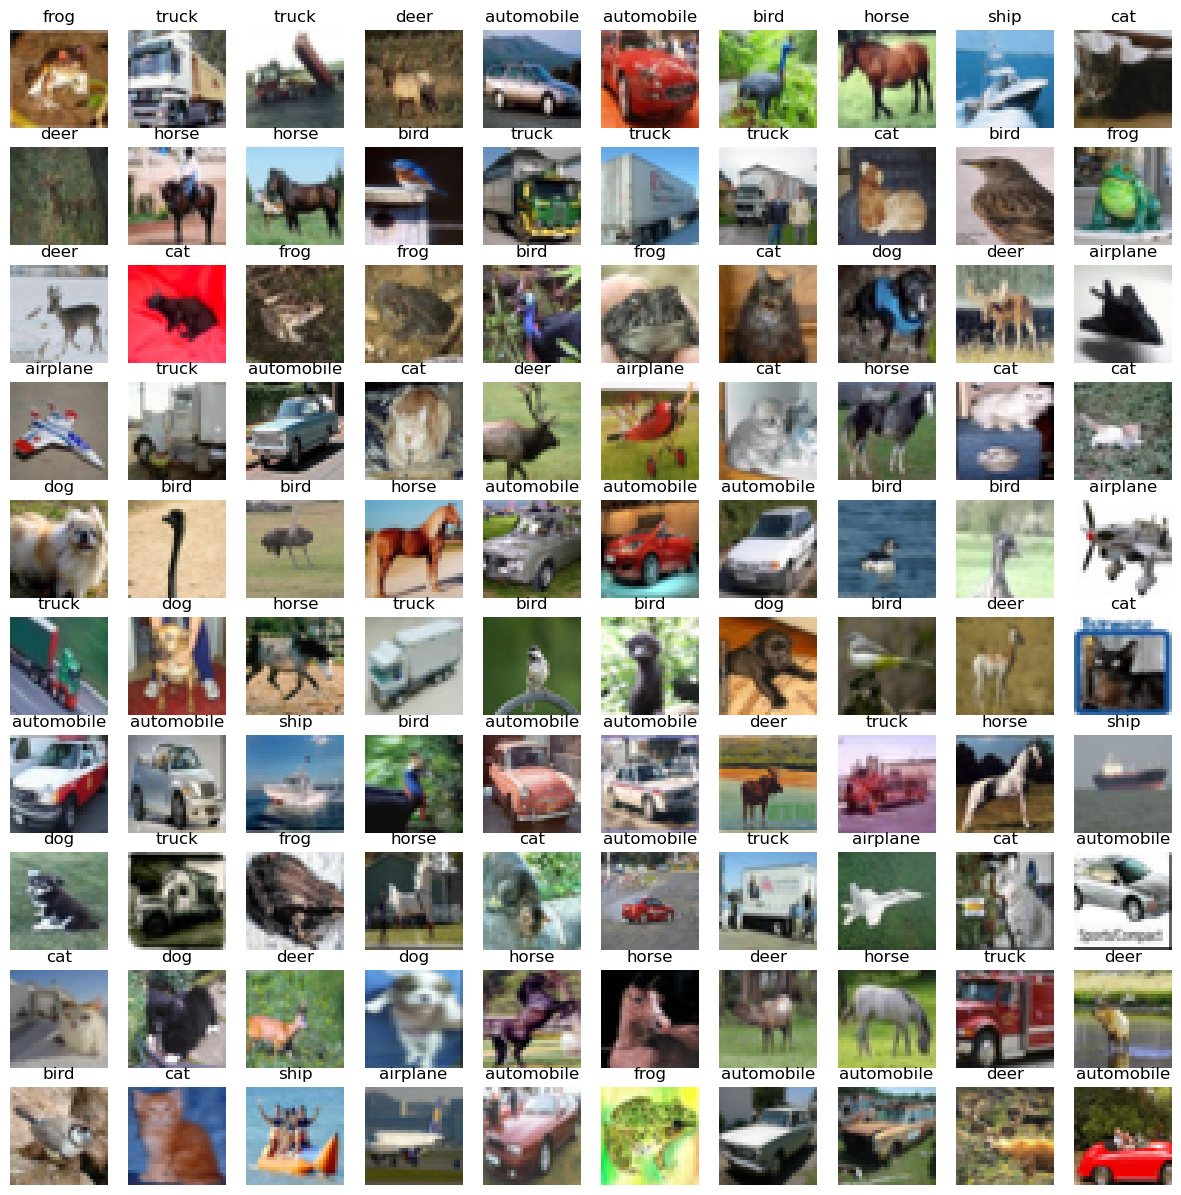

In [4]:
display = True

if display:
    # getting some information from the dataloaders
    labels_map = {
        0: "airplane",
        1: "automobile",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }

    train_features, train_labels = next(iter(dl_train))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print(f"Label: {labels_map[label.item()]}")

    plt.figure(figsize = (15, 15))
    for i in range (100):
        plt.subplot(10, 10, i+1)
        plt.imshow(ds_orig.data[i])
        plt.axis('off')
        plt.title(ds_orig.classes[ds_orig.targets[i]]) # titles are above the images

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

In [13]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

# Simple function to count the parameters in a model.
def count_parameters(model):
    return np.sum([p.numel() for p in model.parameters()])

In [14]:
# A simple MLP model with two hidden layers, this will be out baseline.
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # images in CIFAR10 are 32x32 pixels and are in colour rgb, so we need to have a correct number of inputs for the model
        self.fc1 = nn.Linear(32*32*3, 128)
        self.fc2 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x.view(len(x), -1))
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

In [20]:
# Training hyperparameters.
device = 'cpu'
lr = 0.001
epochs = 20

# Instantiate our model
model_mlp = MLP().to(device)

Training epoch 19: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:35<00:00,  5.34it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.579     0.588     0.584      1000
           1      0.575     0.634     0.603      1000
           2      0.393     0.408     0.400      1000
           3      0.345     0.326     0.335      1000
           4      0.437     0.473     0.454      1000
           5      0.425     0.358     0.388      1000
           6      0.552     0.506     0.528      1000
           7      0.603     0.526     0.562      1000
           8      0.662     0.629     0.645      1000
           9      0.497     0.613     0.549      1000

    accuracy                          0.506     10000
   macro avg      0.507     0.506     0.505     10000
weighted avg      0.507     0.506     0.505     10000



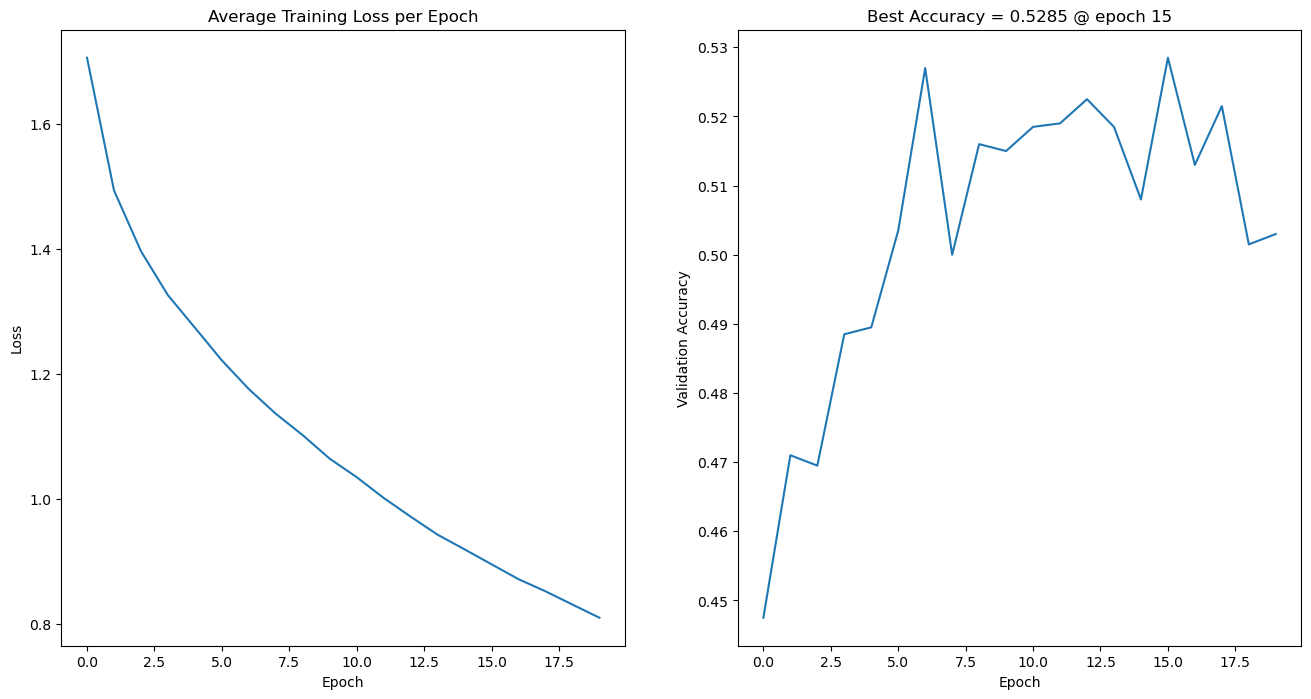

In [21]:
# Set our optimizer.
optimizer = torch.optim.Adam(model_mlp.parameters(), lr = lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

Training epoch 9: 100%|██████████████████████████████████████████████████████████████| 188/188 [00:35<00:00,  5.32it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.576     0.624     0.599      1000
           1      0.624     0.595     0.609      1000
           2      0.410     0.403     0.407      1000
           3      0.337     0.332     0.334      1000
           4      0.454     0.440     0.447      1000
           5      0.409     0.431     0.420      1000
           6      0.564     0.549     0.556      1000
           7      0.593     0.574     0.583      1000
           8      0.643     0.657     0.650      1000
           9      0.562     0.567     0.564      1000

    accuracy                          0.517     10000
   macro avg      0.517     0.517     0.517     10000
weighted avg      0.517     0.517     0.517     10000



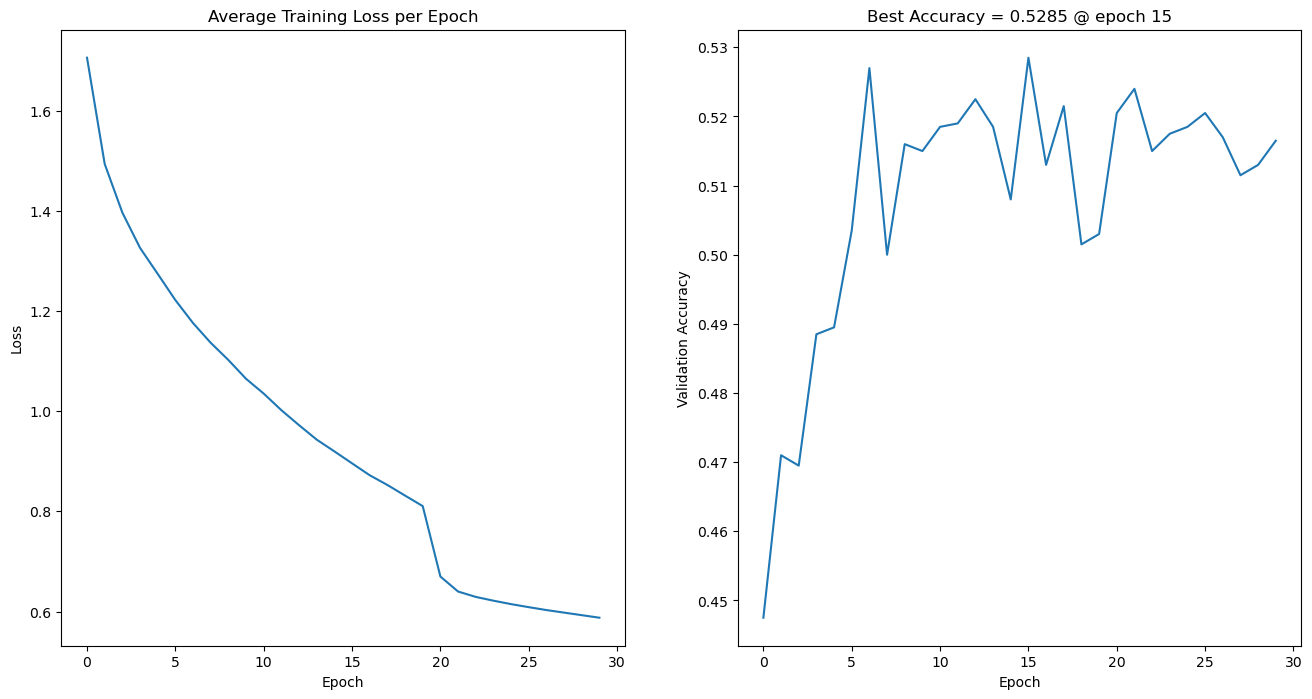

In [22]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 10

# Set our optimizer.
optimizer = torch.optim.Adam(model_mlp.parameters(), lr = lr)

# Our outer training loop, collect loss on train and accuracy on validation.
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

Training epoch 9: 100%|██████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.00it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.573     0.626     0.598      1000
           1      0.619     0.599     0.609      1000
           2      0.418     0.404     0.411      1000
           3      0.345     0.337     0.341      1000
           4      0.459     0.445     0.452      1000
           5      0.414     0.413     0.413      1000
           6      0.550     0.574     0.562      1000
           7      0.578     0.577     0.578      1000
           8      0.652     0.647     0.649      1000
           9      0.564     0.561     0.563      1000

    accuracy                          0.518     10000
   macro avg      0.517     0.518     0.518     10000
weighted avg      0.517     0.518     0.518     10000



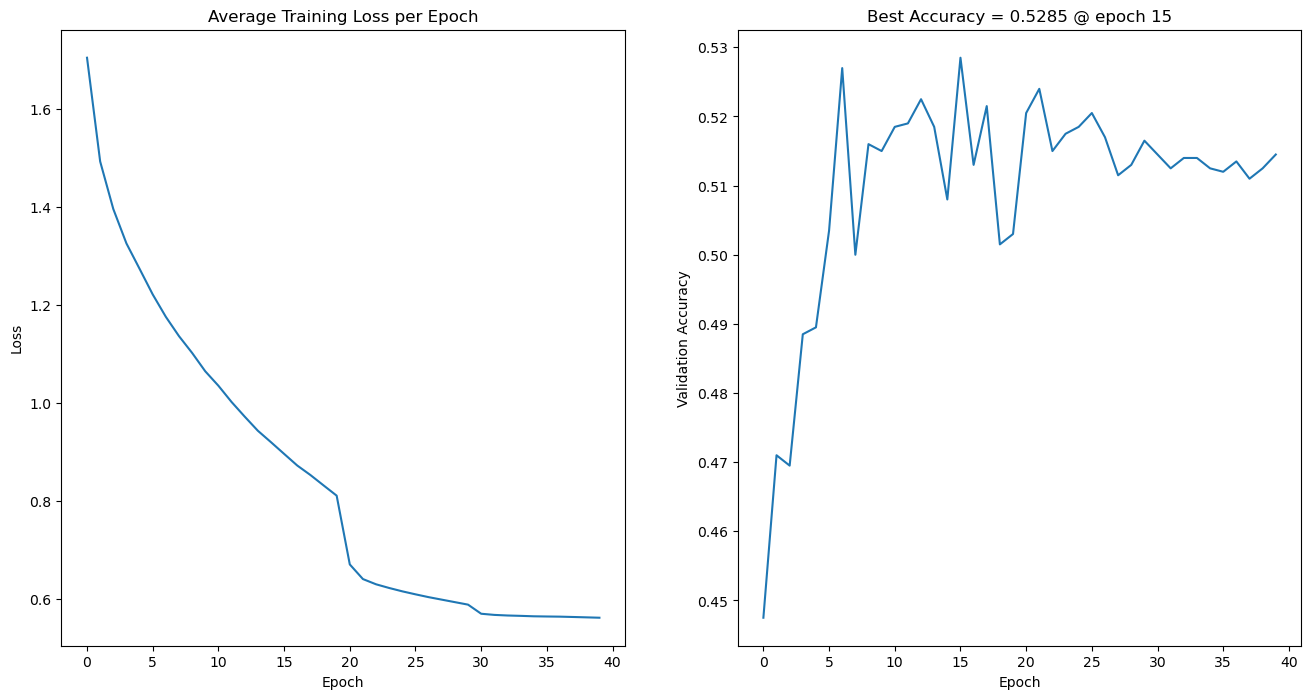

In [23]:
# Training hyperparameters.
device = 'cpu'
lr = 0.00001
epochs = 10

# Set our optimizer.
optimizer = torch.optim.Adam(model_mlp.parameters(), lr = lr)

# Our outer training loop, collect loss on train and accuracy on validation.
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, optimizer, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_mlp, dl_test, device=device)[1]}')

#### Analysis:

After training for 20 epochs with a learning rate of 0.001 we can see that the loss is continuing to decline so we are not overfitting yet, but the accuracy on the validation set is not very good. After that we train for 10 more epochs with a smaller lr, and 10 more after that. Loss is continuing to go down a bit but the validation accuracy doesn't seem to get better. In the end, the best accuracy we got was at epoch 15 accuracy of 0.53 (on validation set), so not that good.

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

In [24]:
# accessing a single image ds_train.data[i] pr ds_train[9][0]

# A simply Convolutional Neural Network with two convolutional layers followed by maxpools.
# The final convolutional layer is fed into two fully-connected layers followed by the
# final output logits.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.conv3 = nn.Conv2d(32, 16, (3, 3))
        self.conv4 = nn.Conv2d(16, 16, (3, 3))
        self.fc1 = nn.Linear(400, 128)
        self.fc2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, xs):
        x = self.relu(self.conv1(xs))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(len(x), -1)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return x

### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before.

Training epoch 19: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.677     0.803     0.735      1000
           1      0.823     0.860     0.841      1000
           2      0.635     0.501     0.560      1000
           3      0.516     0.512     0.514      1000
           4      0.631     0.708     0.667      1000
           5      0.598     0.622     0.610      1000
           6      0.770     0.809     0.789      1000
           7      0.807     0.703     0.751      1000
           8      0.817     0.790     0.803      1000
           9      0.839     0.785     0.811      1000

    accuracy                          0.709     10000
   macro avg      0.711     0.709     0.708     10000
weighted avg      0.711     0.709     0.708     10000



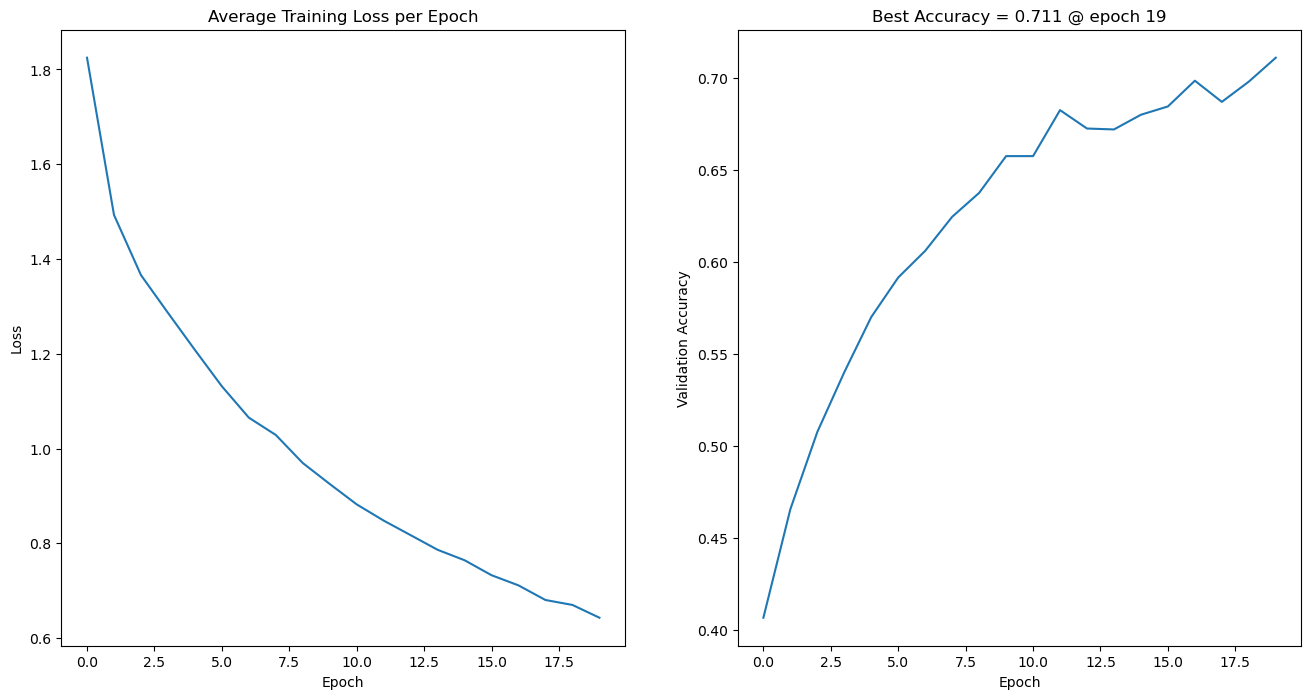

In [27]:
# Training hyperparameters.
device = 'cpu'
lr = 0.001
epochs = 20

model_cnn = CNN().to(device)
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer_cnn, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

Training epoch 9: 100%|██████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.738     0.753     0.745      1000
           1      0.856     0.826     0.841      1000
           2      0.620     0.573     0.596      1000
           3      0.551     0.515     0.532      1000
           4      0.648     0.700     0.673      1000
           5      0.663     0.620     0.641      1000
           6      0.783     0.805     0.794      1000
           7      0.738     0.790     0.763      1000
           8      0.802     0.837     0.819      1000
           9      0.815     0.813     0.814      1000

    accuracy                          0.723     10000
   macro avg      0.721     0.723     0.722     10000
weighted avg      0.721     0.723     0.722     10000



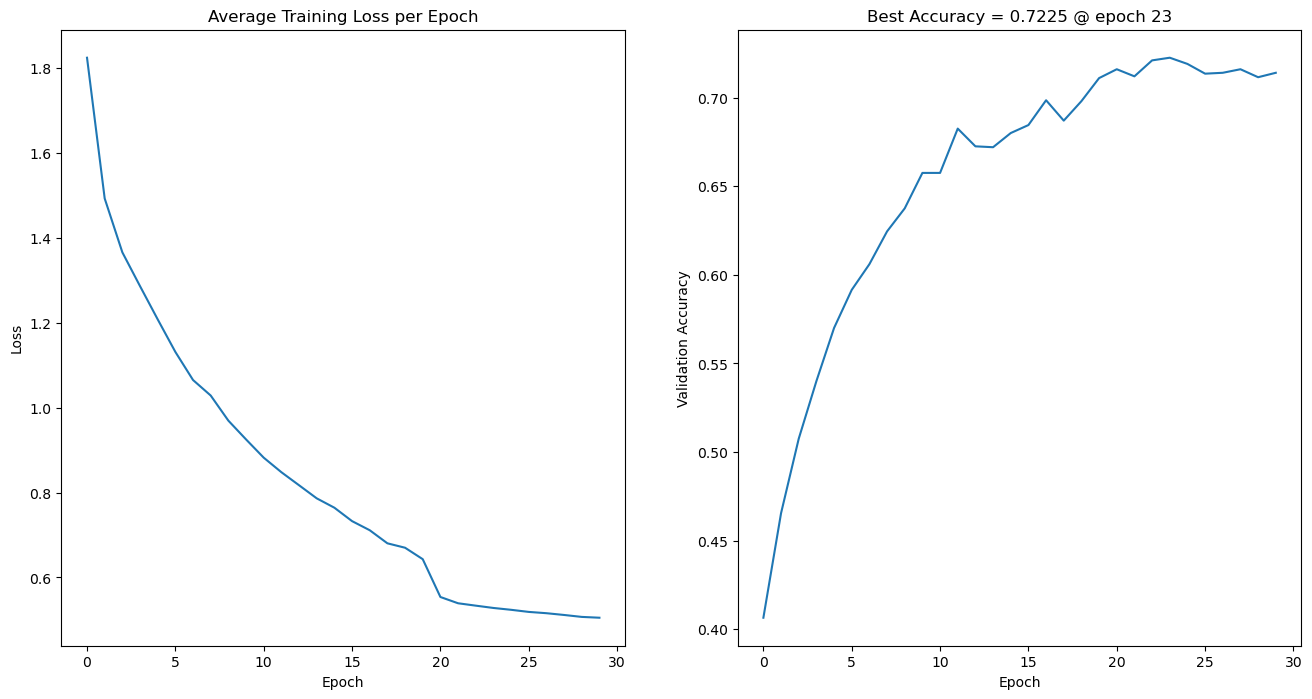

In [28]:
# Training hyperparameters.
device = 'cpu'
lr = 0.0001
epochs = 10
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer_cnn, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

Training epoch 9: 100%|██████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.742     0.746     0.744      1000
           1      0.847     0.838     0.843      1000
           2      0.615     0.579     0.596      1000
           3      0.543     0.520     0.531      1000
           4      0.661     0.671     0.666      1000
           5      0.644     0.636     0.640      1000
           6      0.792     0.800     0.796      1000
           7      0.752     0.775     0.763      1000
           8      0.810     0.832     0.821      1000
           9      0.801     0.829     0.815      1000

    accuracy                          0.723     10000
   macro avg      0.721     0.723     0.721     10000
weighted avg      0.721     0.723     0.721     10000



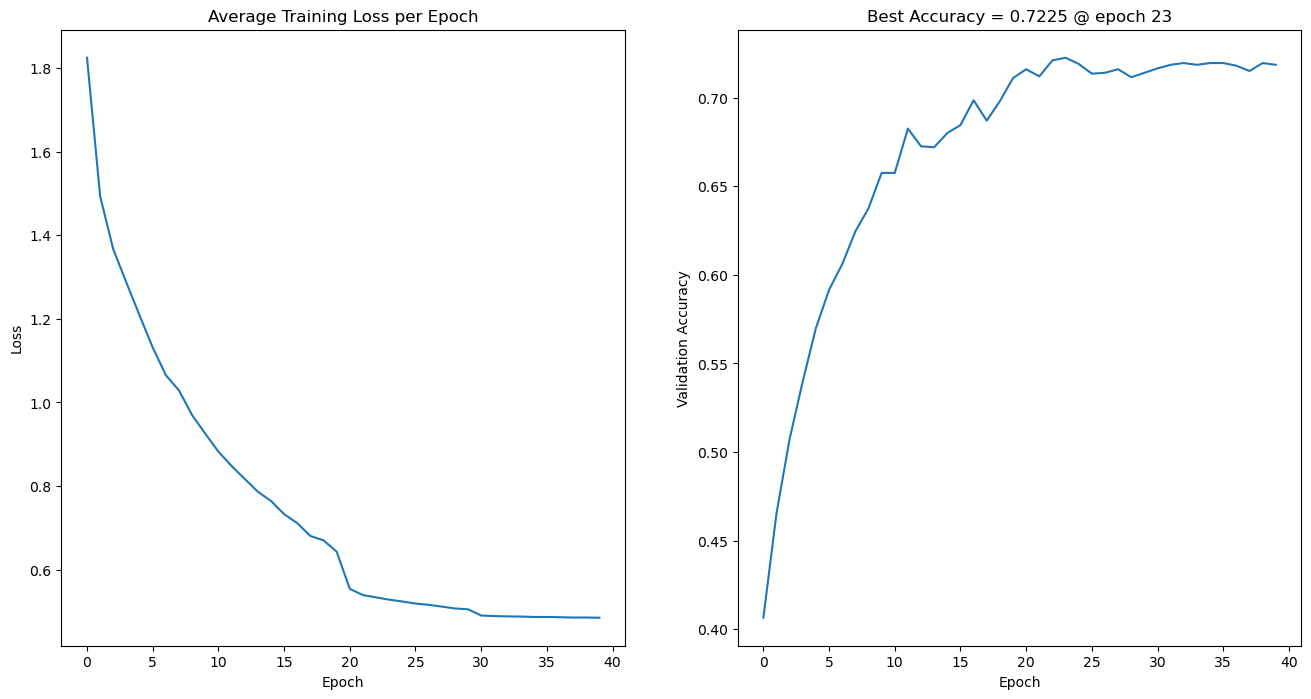

In [29]:
# Training hyperparameters.
device = 'cpu'
lr = 0.00001
epochs = 10
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer_cnn, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

Training epoch 29: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:55<00:00,  3.38it/s]


Accuracy report on TEST
:               precision    recall  f1-score   support

           0      0.739     0.756     0.747      1000
           1      0.850     0.835     0.843      1000
           2      0.607     0.585     0.596      1000
           3      0.544     0.522     0.533      1000
           4      0.653     0.688     0.670      1000
           5      0.649     0.630     0.640      1000
           6      0.781     0.808     0.794      1000
           7      0.748     0.780     0.764      1000
           8      0.829     0.811     0.820      1000
           9      0.821     0.814     0.817      1000

    accuracy                          0.723     10000
   macro avg      0.722     0.723     0.722     10000
weighted avg      0.722     0.723     0.722     10000



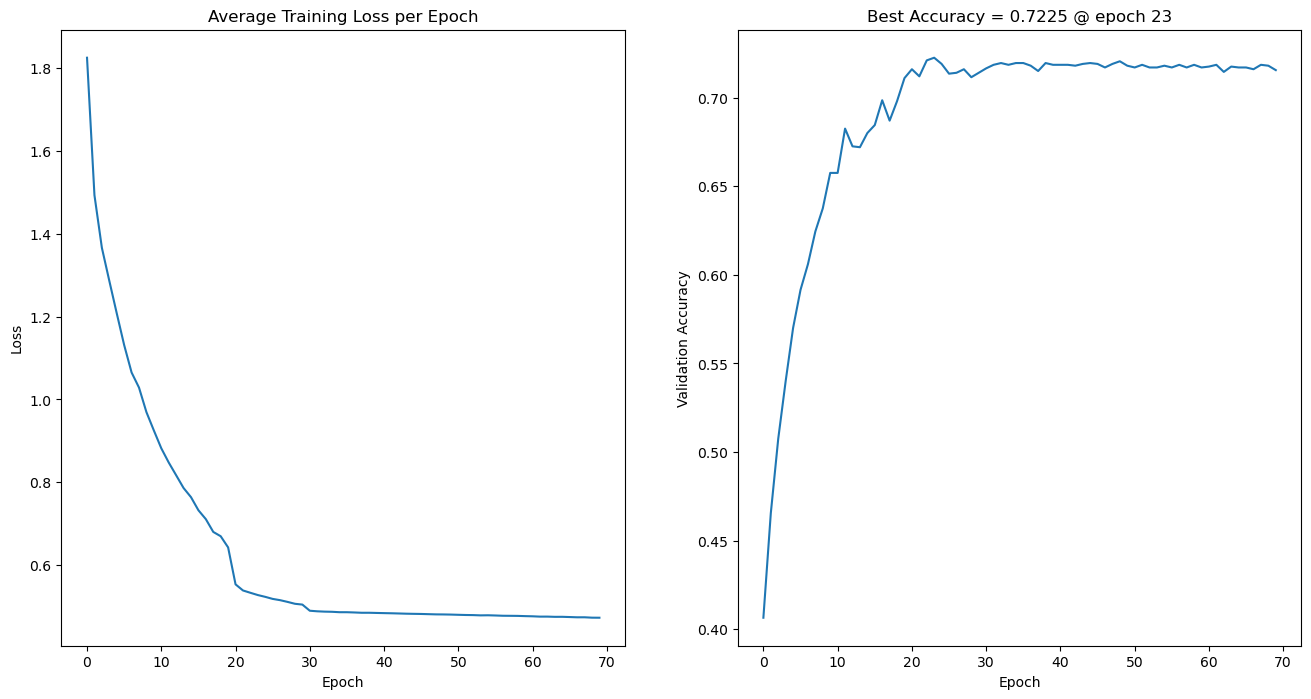

In [30]:
# Training hyperparameters.
device = 'cpu'
lr = 0.00001
epochs = 30
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# Our outer training loop, collect loss on train and accuracy on validation.
for epoch in range(epochs):
    loss = train_epoch(model_cnn, dl_train, optimizer_cnn, epoch, device=device)
    (val_acc, _) = evaluate_model(model_cnn, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))
    
# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST\n: {evaluate_model(model_cnn, dl_test, device=device)[1]}')

#### Analysis:

After training for 20 epochs with a learning rate of 0.001 we can see that the loss is continuing to decline so we are not overfitting yet, but the accuracy on the validation set is not very good. After that we train for 10 more epochs with a smaller lr, and 10 more after that. The best accuracy on validation set that we get is at epoch 23 at 0.72. Just to see what would happen, I tried training with the same learning rate for 30 more epochs, we can see that accuracy is stabilized and learning rate stays the same.

## Going Forward

In practice we usually don't train deep models from *scratch*. Especially if we don't have a lot of annotated data we almost always use a **pre-trained** model either as a **feature extractor** or to **fine-tune** on our problem. The Torchvision library supports access to a [huge variety or pre-trained models](https://pytorch.org/vision/stable/models/resnet.html) that you can use for *exactly* this purpose. Keep this in mind if you have an image recognition problem -- you can use a pre-trained model as a **feature extractor** and then train a *simple* MLP to solve your classification problem. This works *very* well in practice.